# COVID-19 Vaccine Tweet Sentiment Analysis

We will perform sentiment analysis on tweets about COVID-19 vaccines using the **fastai** library.

## Transfer learning in NLP - the ULMFiT approach

We will be making use of transfer learning to help us create a model to analyse tweet sentiment. The idea behind transfer learning is that neural networks learn information that generalises to new problems, particularly the early layers of the network.

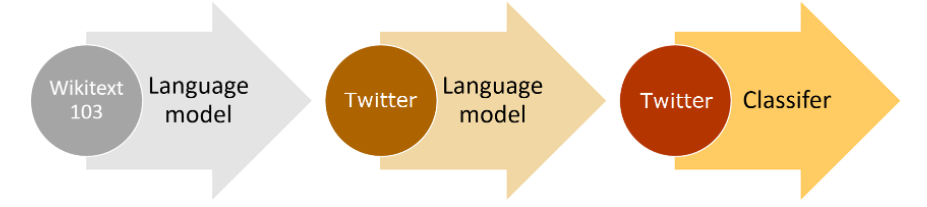


We can use our new classifier to analyse sentiment in the COVID-19 vaccine tweets and compare changes in sentiment over time to the progress of vaccination in different countries.

### For proper text format

In [1]:
import pandas as pd

In [2]:
pd.set_option("display.max_colwidth", -1)

<ipython-input-2-a09e5efec013>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


## Loading Data

### Import fastai text module

In [3]:
!pip install -U fastai

You should consider upgrading via the 'c:\users\samruddhi naik\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
from fastai.text.all import *

### Load dataset

In [ ]:
vax_tweets = pd.read_csv('vaccination_all_tweets.csv')
vax_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


We could use the text column of this dataset to train a Twitter language model, but since our end goal is sentiment analysis we will need to find another dataset that also contains sentiment labels to train our classifier.

In [ ]:
tweets = pd.read_csv('tweet_dataset.csv')
tweets.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier and i started freakin at his part =[,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"We want to trade with someone who has Houston tickets, but no one will.","@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",82565a56d3,neutral,"We want to trade with someone who has Houston tickets, but no one will."


### Data Cleaning



For our language model, the only input we need is the tweet text. As we will see in a moment fastai can handle text preprocessing and tokenization for us, but it might be a good idea to remove things like **twitter handles, urls, hashtags and emojis** first. There are also some rows with **blank tweets** which need to be removed.

We ideally want the language model to learn not just about tweet language, but more specifically about vaccine tweet language. We can therefore use text from both datasets as input for the language model. For the classification model we need to remove all rows with missing sentiment, however.



In [ ]:
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']

# Clean the text data and combine the dfs
tweets = tweets[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'sentiment'})
vax_tweets['sentiment'] = np.nan
tweets = tweet_proc(tweets)
vax_tweets = tweet_proc(vax_tweets)
df_lm = tweets[['text', 'sentiment']].append(vax_tweets[['text', 'sentiment']])
df_clas = df_lm.dropna(subset=['sentiment'])
print(len(df_lm), len(df_clas))

147312 31323


In [ ]:
df_clas.head()

,text,sentiment
1,Layin n bed with a headache ughhhh...waitin on your call...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral
5,Re-pinging why didn't you go to prom? BC my bf didn't like my friends,negative


In [ ]:
df_lm

,text,sentiment
0,i know i was listenin to bad habit earlier and i started freakin at his part =[,NaN
1,Layin n bed with a headache ughhhh...waitin on your call...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral
...,...,...
107384,How do issues with compare with other vaccines such as the annual,NaN
107385,Those making issue of should know that is also not approved for EUL in US,NaN
107386,EMBARRASSING Ontario is reporting 574 cases of 109 new cases in Toronto. Canada politicizing,NaN
107387,EMBARRASSING Ontario is reporting 574 cases of 109 new cases in Toronto. Canada politicizing Doug,NaN


## Training a language model

To train our language model we can use self-supervised learning; we just need to give the model some text as an independent variable and fastai will automatically preprocess it and create a dependent variable for us. We can do this in one line of code using the DataLoaders class, which converts our input data into a DataLoader object that can be used as an input to a fastai Learner.

In [ ]:
dls_lm = TextDataLoaders.from_df(df_lm, text_col='text', is_lm=True, valid_pct=0.1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Here we told fastai that we are working with text data, which is contained in the text column of a pandas DataFrame called df_lm. We set is_lm=True since we want to train a language model, so fastai needs to label the input data for us. Finally, we told fastai to hold out a random 10% of our data for a validation set using valid_pct=0.1.

Let's take a look at the first two rows of the DataLoader using show_batch.

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj moscow in talks with xxmaj vienna on possible supplies of vaccine xxbos ang xxunk ko na , yes ! hoping to go down to my xxmaj melbourne weight from last year xxbos xxmaj now we will import \n\n modiji ke xxunk xxunk … . xxbos 560024 , \n xxup age 45 + \n 18-d1 , 19-d2 slots , \n▁ on 19 - 06 - 2021 \n @ xxup columbia xxup","xxmaj moscow in talks with xxmaj vienna on possible supplies of vaccine xxbos ang xxunk ko na , yes ! hoping to go down to my xxmaj melbourne weight from last year xxbos xxmaj now we will import \n\n modiji ke xxunk xxunk … . xxbos 560024 , \n xxup age 45 + \n 18-d1 , 19-d2 slots , \n▁ on 19 - 06 - 2021 \n @ xxup columbia xxup asia"
1,"of ? lol xxbos xxmaj report for xxmaj unspecified ( may 28 , 2021 ) : xxbos i know it 's in xxup hd , but xxmaj comcast does n't have it . xxbos brill i 'll try and keep an eye on twitter , did n't help yesterday , ran outta battery right when i needed it . xxbos i wish our very own boosts it 's production to meet our","? lol xxbos xxmaj report for xxmaj unspecified ( may 28 , 2021 ) : xxbos i know it 's in xxup hd , but xxmaj comcast does n't have it . xxbos brill i 'll try and keep an eye on twitter , did n't help yesterday , ran outta battery right when i needed it . xxbos i wish our very own boosts it 's production to meet our requirements"


We have a new column, text_, which is text offset by one. This is the dependent variable fastai created for us. By default fastai uses word tokenization, which splits the text on spaces and punctuation marks and breaks up words like can't into two separate tokens. fastai also has some special tokens starting with 'xx' that are designed to make things easier for the model; for example xxmaj indicates that the next word begins with a capital letter and xxunk represents an unknown word that doesn't appear in the vocabulary very often. You could experiment with subword tokenization instead, which will split the text on commonly occuring groups of letters instead of spaces. This might help if you wanted to leave hashtags in since they often contain multiple words joined together with no spaces, e.g. #CovidVaccine.

### Fine-tuning the language model

The next step is to create a language model using language_model_learner.

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

Here we passed language_model_learner our DataLoaders, dls_lm, and the pre-trained RNN model, AWD_LSTM, which is built into fastai. drop_mult is a multiplier applied to all dropouts in the AWD_LSTM model to reduce overfitting. For example, by default fastai's AWD_LSTM applies EmbeddingDropout with 10% probability (at the time of writing), but we told fastai that we want to reduce that to 3%. The metrics we want to track are perplexity, which is the exponential of the loss (in this case cross entropy loss), and accuracy, which tells us how often our model predicts the next word correctly. We can also train with fp16 to use less memory and speed up the training process.

We can find a good learning rate for training using lr_find and use that to fit our model.

SuggestedLRs(valley=tensor(0.0052))

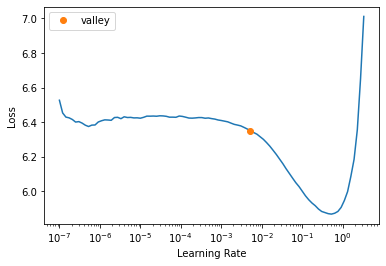

In [ ]:
learn.lr_find()

When we created our Learner the embeddings from the pre-trained AWD_LSTM model were merged with random embeddings added for words that weren't in the vocabulary. The pre-trained layers were also automatically frozen for us. Using fit_one_cycle with our Learner will train only the new random embeddings (i.e. words that are in our Twitter vocab but not the Wikipedia vocab) in the last layer of the neural network.

In [ ]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.060002,3.955819,0.309455,52.238453,02:47


After one epoch our language model is predicting the next word in a tweet around 25% of the time - not too bad! We can unfreeze the entire model, find a more suitable learning rate and train for a few more epochs to improve the accuracy further.

SuggestedLRs(valley=tensor(7.5858e-05))

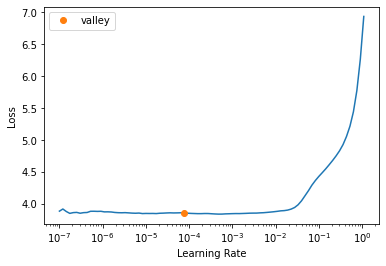

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.704652,3.787425,0.331440,44.142590,02:50
1,3.554456,3.677401,0.347936,39.543491,02:50
2,3.347580,3.646449,0.355686,38.338299,02:49
3,3.247556,3.658561,0.356225,38.805443,02:50


After a bit more training we can predict the next word in a tweet around 29% of the time. Let's test the model out by using it to write some random tweets (in this case it will generate some text following 'I love').

In [ ]:
# Text generation using the language model
TEXT = "I love"
N_WORDS = 30
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i love my new musical The Union Health Ministry has approved the emergency use of the vaccine against coronavirus by the Health Ministry
i love you too Bharat Biotech said it has been found that this vaccine is effective against Indian variants of sars - cov-2 and effectively neutralises the double


Let's save the model encoder so we can use it to fine-tune our classifier. The encoder is all of the model except for the final layer, which converts activations to probabilities of picking each token in the vocabulary. We want to keep the knowledge the model has learned about tweet language but we won't be using our classifier to predict the next word in a sentence, so we won't need the final layer any more.

In [ ]:
learn.save_encoder('finetuned_lm')

## Training a sentiment classifier

To get the DataLoaders for our classifier let's use the DataBlock API this time, which is more customisable

In [ ]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('sentiment'),
    splitter=RandomSplitter()
).dataloaders(df_clas, bs=64)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


To use the API, fastai needs the following:

* blocks:
  * TextBlock: Our x variable will be text contained in a pandas DataFrame. We want to use the same sequence length and vocab as the language model DataLoaders so we can make use of our pre-trained model.
  * CategoryBlock: Our y variable will be a single-label category (negative, neutral or positive sentiment).
* get_x, get_y: Get data for the model by reading the text and sentiment columns from the DataFrame.
* splitter: We will use RandomSplitter() to randomly split the data into a training set (80% by default) and a validation set (20%).
* dataloaders: Builds the DataLoaders using the DataBlock template we just defined, the df_clas DataFrame and a batch size of 64.

We can call show batch as before; this time the dependent variable is sentiment.

In [ ]:
dls_clas.show_batch(max_n=2)

,text,category
0,xxbos xxup pirate xxup voice : xxrep 3 a xxrep 3 r xxrep 3 g xxrep 3 h xxrep 3 ! i 4got xxup my xxup damn xxup wallet xxup at xxup work xxup xxunk xxrep 3 ! xxup dammit xxrep 3 ! xxup so xxup close xxup yet xxup so xxup far xxrep 3 ! xxup now xxup i m xxup starving xxrep 3 !,negative
1,"xxbos xxup mad xxup as xxup hell ! xxup someone xxup stole xxup my xxup pink & & xxup black xxup xxunk xxup print xxup pumps i xxup wanted xxup to xxup wear xxup today xxup but xxup to xxup god xxup be xxup the xxup glory , xxup he 'll xxup bless xxup me xxup xxunk",negative


Initialising the Learner is similar to before, but in this case we want a text_classifier_learner.

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

Finally, we want to load the encoder from the language model we trained earlier, so our classifier uses pre-trained weights.

In [ ]:
learn = learn.load_encoder('finetuned_lm')

### Fine-tuning the classifier

Now we can train the classifier using discriminative learning rates and gradual unfreezing, which has been found to give better results for this type of model. First let's freeze all but the last layer

In [ ]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.840333,0.751895,0.656450,00:35


Now freeze all but the last two layers

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.731493,0.635181,0.732280,00:35


Now all but the last three

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.634732,0.575252,0.764208,00:36


Finally, let's unfreeze the entire model and train a bit more

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.603525,0.571745,0.768519,00:37
1,0.570695,0.564596,0.771073,00:37
2,0.524081,0.567967,0.769955,00:37


In [ ]:
learn.save('classifier')

Path('models/classifier.pth')

Our model correctly predicts sentiment around 75% of the time. We could perhaps do better with a larger dataset as mentioned earlier, or different model hyperparameters. It might be worth experimenting with this yourself to see if you can improve the accuracy.

We can quickly sense check the model by calling predict, which returns the predicted sentiment, the index of the prediction and predicted probabilities for negative, neutral and positive sentiment.

In [ ]:
learn.predict("I love")

('positive', tensor(2), tensor([5.0074e-04, 1.2601e-03, 9.9824e-01]))

In [ ]:
learn.predict("I hate")

('negative', tensor(0), tensor([0.9944, 0.0027, 0.0030]))

## Analysing the tweets

To carry out sentiment analysis on the vaccine tweets, we can add them to the DataLoaders as a test set

In [ ]:
pred_dl = dls_clas.test_dl(vax_tweets['text'])

In [ ]:
preds = learn.get_preds(dl=pred_dl)

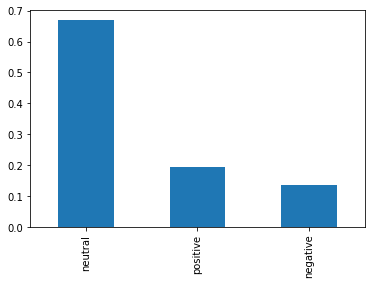

In [ ]:
# Get predicted sentiment
vax_tweets['sentiment'] = preds[0].argmax(dim=-1)
vax_tweets['sentiment'] = vax_tweets['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'})

# Convert dates
vax_tweets['date'] = pd.to_datetime(vax_tweets['date'], errors='coerce').dt.date

# Save to csv
vax_tweets.to_csv('vax_tweets_sentiment.csv')

# Plot sentiment value counts
vax_tweets['sentiment'].value_counts(normalize=True).plot.bar();

We can see that the predominant sentiment is neutral, with slightly more positive tweets than negative. It's encouraging that negative sentiment isn't higher! We can also visualise how sentiment changes over time

In [ ]:
# Remove today's date since data is incomplete
today = pd.Timestamp.today().date()
vax_tweets = vax_tweets[vax_tweets['date']!=today]

# Get counts of number of tweets by sentiment for each date
timeline = vax_tweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

# Plot results
import plotly.express as px
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

There was a big spike in the number of tweets on March 1st 2021 and further more days

## Timeline analysis

A lot of the tweets appear to be from users in India

In [ ]:
spike = vax_tweets[vax_tweets['date'].astype(str)=='2021-03-01']
spike['user_location'].value_counts(ascending=False).head(10)

India               258
New Delhi, India    138
patna                52
Mumbai, India        48
New Delhi            46
Bengaluru, India     32
Mumbai               28
Delhi                26
Hyderabad, India     24
Pune, India          22
Name: user_location, dtype: int64

In [ ]:
spike = spike.sort_values('user_location', ascending=False)
spike['orig_text'].head()

18084                        Before magreact, do the research how the vaccine works, regardless the brands and the efficacy rates. #TheVaccineIsSafe #Sinovac
17555          I find this Photo by @cpimspeak\nTo be offensive and degrading , \nIt is depicting something truly against the commun… https://t.co/X51R4sFQYq
15285                 🇮🇳 PM Shri @narendramodi took his first dose of the #COVID19 #Vaccine at AIIMS Delhi today.\nHe led the way in… https://t.co/tKLRgz3vml
16532          Got call at 9 am from health department and mom got #COVAXIN shot at 1 pm.\n\nThey do really care about their citizen… https://t.co/VdMUMXS9Nx
16901    #mRNAvaccine #PfizerBionTech\n#Moderna #Katalinkariko\n#NianshuangWang #Mclellan\n\nAs for J&amp;J, Astrazeneca, the effcti… https://t.co/tK1U6LFboZ
Name: orig_text, dtype: object

It looks like Indian Prime Minister Narendra Modi received the first dose of Indian developed Covaxin on 1st March.

In [ ]:
spike = vax_tweets[vax_tweets['date'].astype(str)=='2021-04-21']
spike['user_location'].value_counts(ascending=False).head(10)

India                             170
New Delhi, India                   90
Toronto, Canada  and Worldwide     74
Mumbai, India                      56
Bengaluru, India                   47
New Delhi                          27
Hyderabad, India                   24
भारत                               23
Chennai                            19
Mumbai                             19
Name: user_location, dtype: int64

In [ ]:
spike = spike.sort_values('user_location', ascending=False)
spike['orig_text'].head()

65884     @HINDU_AJ It's pretty obvious, good thing is they have their  tongues tied on #covaxin now that it's ormisisng resu… https://t.co/xc4MwNbPpj
61504                                                                                                                Got my first shot! TyG 😘 #Sinovac
62408    *awards show voice*:\n\nI’d like to thank @dollyparton for making this moment possible! 🥺 #VaxUpSavannah #SecondDose… https://t.co/IRurILNL5z
68062              I knew there was something fishy when EMA started pussyfooting about #SputnikV approvals; it was to ensure… https://t.co/efIGHzp8gQ
66575                    #Covaxin Neutralises Multiple Variants Of Covid-19 Virus Including Double Mutant Strain: ICMR Study.… https://t.co/Mgu4zem56W
Name: orig_text, dtype: object

Note this tweet - #Covaxin Neutralises Multiple Variants Of Covid-19 Virus Including Double Mutant Strain: ICMR Study

In [ ]:
spike = vax_tweets[vax_tweets['date'].astype(str)=='2021-06-08']
spike['user_location'].value_counts(ascending=False).head(10)

India               129
Michigan, USA        95
New Delhi, India     76
Mumbai, India        51
New Delhi            31
Chennai, India       23
Mumbai               19
Hyderabad, India     18
Bengaluru, India     18
Delhi                14
Name: user_location, dtype: int64

In [ ]:
spike = spike.sort_values('user_location', ascending=False)
spike['orig_text'].head()

96628     #Moderna has applied to Health Canada to approve the use of its vaccine on 12 to 17-year olds. \n\nThe company said c… https://t.co/lFMeM4hBXg
92286       @UNICEF @unicefchief Advice #WHO to testify and give approval to vaccines like #Covaxin or such, Because of their s… https://t.co/RS0NmbTuhV
96656       So I see that #Fauxi has fulfilled his part of the deal with #Moderna from 2015. Come near my kids, you better pray… https://t.co/uKzXSs05aP
91458     Govt Announces prices for vaccines for private hospitals.. \n\nThe below prices include 5% GST and ₹ 150 service char… https://t.co/hJghswV1GE
100337                                           Why? Can someone explain me why?\n\n#Russian #Sputnikvaccine #SputnikV #vaccine https://t.co/IpXB5qyv1F
Name: orig_text, dtype: object

Note this tweet - 

Govt Announces prices for vaccines for private hospitals.. 
The below prices include 5% GST and ₹ 150 service charge.. 
Max price for #Covishield ₹ 780/ dose, #Covaxin ₹ 1,410/ dose, #Sputnik ₹ 1,145/ dose.. 

## Plot timelines for each vaccine indvidually

### Covaxin

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['orig_text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['orig_text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(vax_tweets, ['covaxin'], title='Covaxin')

In [ ]:
# Function to filter the data to a single date and print tweets from users with the most followers
def date_filter(df, date):
    return df[df['date'].astype(str)==date].sort_values('user_followers', ascending=False)[['date' ,'orig_text']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(covaxin, ['2021-03-01', '2021-03-03', '2021-04-21', '2021-05-16', '2021-06-17'])

,date,orig_text
18936,2021-03-01,"""Felt secure, will travel safely"" EAM @DrSJaishankar receives his first shot of #Covaxin today \n\n#COVID19Vaccine… https://t.co/mkNsMDuJ5a"
17463,2021-03-01,#Watch | PM @NarendraModi was administered the first dose of Bharat Biotech’s #COVAXIN at AIIMS. \n\nThe vaccine was… https://t.co/Du3exryYQw
13382,2021-03-01,"@nistula Sources in the govt say PM #NarendraModi took the Indian researched and made #Covaxin by #BharatBiotech,ad… https://t.co/Z2nkbIfdRg"
13107,2021-03-01,"PM #NarendraModi took the first shot of #COVAXIN , the Indian researched and produced anti-COVID19 vaccine at AIIMS… https://t.co/0ORXTDXGSP"
18912,2021-03-01,There are two #CovidVaccines that are being used in India right now - Bharat Biotech's #Covaxin and Serum Institute… https://t.co/yqHUdBSebB
18960,2021-03-01,External Affairs Minister Jaishankar receives first dose of #Covaxin.\n#CovidVaccine #vaccination \n#LiveUpdates here… https://t.co/bTp57fZwML
18750,2021-03-01,"A 100-year-old resident of #Hyderabad, Jaidev Chowdhry, received his first dose of the Covid-19 vaccine, #Covaxin,… https://t.co/sQui1oMkFX"
18700,2021-03-01,"#PMModi took the first does of #Covid19 vaccine, #Covaxin, today. #NewsTrack #Video\nhttps://t.co/I2GTmtsGnt"
18666,2021-03-01,#PMModi took the first dose of #Covaxin today. Will this give the necessary boost to #vaccination drive in India? W… https://t.co/b26yz03azM
18803,2021-03-01,#PMModi flagged off the second phase of #Covid19 #vaccination today as he took his first dose of #Covaxin at #AIIMS… https://t.co/5F1OcGiJmn


,date,orig_text
20792,2021-03-03,"#Covaxin 81% Effective, Works Against UK Variant, Claims Bharat Biotech \n\nRead more: https://t.co/8XogSMns7c https://t.co/GmjX8APbYM"
20388,2021-03-03,"“The data is quite encouraging”: Dr Rachna Kucheria, Epidemiologist, on #Covaxin’s efficacy data https://t.co/hVT667gizB"
20403,2021-03-03,"“The numbers are extremely promising at this stage”: Dr Shekhar C Mande, Director General, CSIR, on #Covaxin's effi… https://t.co/rFoRhl1IEh"
20696,2021-03-03,"#Covaxin's Phase 3 Trial Results Out! #Covid19 Vaccine Efficacy Up At 81%, Says Bharat Biotech\n\nDetails:… https://t.co/FZGlK4PWYD"
20411,2021-03-03,"For those like me who were concerned that #Covaxin was being deployed before its third phase trials were concluded,… https://t.co/AryEWwcCV5"
20563,2021-03-03,"#Covaxin demonstrates the prowess of Atmanirbhar Bharat, says ICMR chief\n\n#COVID19Vaccine \n\nhttps://t.co/ITUyBPekvz https://t.co/kmbmUGf4X3"
20349,2021-03-03,India's vaccine maker Bharat Biotech said Wed its #covid19 #vaccine #Covaxin has demonstrated 81% interim efficacy… https://t.co/9egL9TJIV5
20380,2021-03-03,#Covaxin is one of the two vaccines that have been granted emergency use approval in India\n#CoronaVaccine… https://t.co/9lKj4Sn1Of
20850,2021-03-03,"Bharat Biotech announces phase 3 results of Covaxin, shows 81% efficacy. \n#5iveLive with @ShivAroor \n#Covaxin… https://t.co/D2yxrNb9Nf"
20671,2021-03-03,.@BharatBiotech announces the phase 3 results of its #CoronavirusVaccine #Covaxin; claims the shots demonstrated an… https://t.co/przGWrxAmN


,date,orig_text
66209,2021-04-21,"#Covaxin shows 78% overall interim efficacy, 100% efficacy against severe Covid: Bharat Biotech &amp; ICMR \n\nREAD: https://t.co/MwQj6kqtRL"
66247,2021-04-21,#BharatBiotech says #Covaxin has shown 78 pc efficacy against mild to severe COVID-19 as per Phase III interim anal… https://t.co/rEVZWaOvpS
66034,2021-04-21,"The second interim phase 3 analysis of the first make-in-India Coronavirus vaccine, #Covaxin, has shown 78% efficac… https://t.co/SHujk7rsuF"
66026,2021-04-21,"#Covaxin's efficacy of 78% was recorded against mild, moderate, and severe symptoms of #Covid19 based on 127 cases,… https://t.co/F9XCzNNjKg"
65559,2021-04-21,"#Covaxin's efficacy of 78% was recorded against mild, moderate, and severe symptoms of #Covid19 based on 127 cases,… https://t.co/DJydP4Dtj5"
66478,2021-04-21,Experts said #Covishield is being produced at a much higher scale than #Covaxin due to which its availability is mo… https://t.co/MLKZLR84DX
66229,2021-04-21,"@neutranino We have 2-4/10,000 breakthrough infections have been reported from #Covaxin &amp; #Covishield. This is a ve… https://t.co/sP4yitrL9I"
66394,2021-04-21,#Covaxin shows 78% efficacy in Phase 3 trials\n#Covid19 #Coronavirus \n#LiveUpdates here : https://t.co/1D9PKwKYJs https://t.co/YJ3gyhJoXP
66610,2021-04-21,#ICMR reveals #Covaxin effective against multiple variants\nMilan Sharma with details \n#ITVideo #Covid19India… https://t.co/XgV51rJmNF
66600,2021-04-21,#ICMR reveals studies have shown #Covaxin neutralises double mutant strain. #Covid19 #coronavirus #Video\nhttps://t.co/phdCCHinPM


,date,orig_text
75686,2021-05-16,"#Covaxin effective against India, UK coronavirus strains: Bharat Biotech https://t.co/GqDTjotMNY https://t.co/nAVc60ljlG"
75946,2021-05-16,"To ramp up the manufacturing of #Covaxin, Bharat Biotech will transfer technology to two Ahmedabad-based companies… https://t.co/olw7IvnmBU"
75589,2021-05-16,"To ramp up the manufacturing of #Covaxin, Bharat Biotech will transfer technology to two Ahmedabad-based companies… https://t.co/wzESzRlcil"
75396,2021-05-16,"To ramp up the manufacturing of #Covaxin, Bharat Biotech will transfer technology to two Ahmedabad-based companies… https://t.co/iEWuaa4Fab"
75837,2021-05-16,"#BharatBiotech’s #Covaxin effective against the new #COVID-19 variants, reveals study\nhttps://t.co/smYhAjyOfI"
75822,2021-05-16,".@BharatBiotech developed #Covaxin effective on B.1.617 and B.1.1.7, emerging variants first identified in India an… https://t.co/sWkOd5il3Q"
75916,2021-05-16,Govt plans to ramp up production of #Covaxin to 10 crore doses per month.\nhttps://t.co/xyQSCPLIQB
75524,2021-05-16,Is #Covishield better or #Covaxin? Everything you should know about coronavirus vaccine\n\n#COVID19 #CoronaVaccine… https://t.co/9EV9mtE3mf
75713,2021-05-16,"#COVAXIN effective against #coronavirusstrains found in India and UK, reveals study\n\n#COVID19 #COVIDVaccine… https://t.co/B7MiMPaCD8"
75375,2021-05-16,"#COVAXIN effective against #coronavirusstrains found in India and UK, reveals study\n\n#COVID19 #COVID19India… https://t.co/khfxBB43UG"


,date,orig_text
105641,2021-06-17,"""News reports on Bharat Biotech submitting Phase-3 data to WHO is incorrect and lacks any evidence"": #COVAXIN maker… https://t.co/hViIbsZFyj"
106256,2021-06-17,"#COVAXIN | Bharat Biotech and World Health Organisation's (WHO) pre-submission meeting on June 23rd, says a WHO document. (ANI)"
105857,2021-06-17,"#Covaxin does not contain calf serum, but the serum is used in the labs to boost the growth of Vero cells, both the… https://t.co/o1FnMXBJ9h"
105596,2021-06-17,"Bharat Biotech dismisses reports it has submitted #Covaxin’s phase 3 trial data to WHO for its approval, reports ANI https://t.co/lf6xCIqbtu"
105314,2021-06-17,"#Covaxin does not contain calf serum, but the serum is used in the labs to boost the growth of Vero cells, both the… https://t.co/8EI6GIdjQe"
105575,2021-06-17,"#Covaxin does not contain calf serum, but the serum is used in the labs to boost the growth of Vero cells, both the… https://t.co/3qwcZX3DMF"
106048,2021-06-17,#India’s vaccine against COVID-19 #Covaxin is set to get closer to World Health Organization (WHO) approval with a… https://t.co/c85HGi2vDs
106262,2021-06-17,"Bharat Biotech and World Health Organisation's (WHO) pre-submission meeting on June 23rd, says a WHO document. \n\n#COVAXIN"
106369,2021-06-17,#DNASpecial | Calf serum in #Covaxin? Congress leader spreads 'fake news' about #BharatBiotech's vaccine… https://t.co/sTnO5geCNe
106192,2021-06-17,WHO's approval for #Covaxin: Bharat Biotech's pre-submission meeting on June 23\n\nhttps://t.co/PfhGUcBkNP https://t.co/lsJ9z9WHB4


As we can see, Modi wasn't the only person to make news on March 1st; India's External Affairs Minister and a 100-year-old Hyderabad resident also received their first dose of Covaxin. On March 3rd, phase 3 trial results for Covaxin were published, showing 81% efficacy. It makes sense for there to be a spike in the number of neutral and positive tweets about Covaxin on those dates!

Note this tweet - 

Experts said #Covishield is being produced at a much higher scale than #Covaxin due to which its availability is more.

.@BharatBiotech developed #Covaxin effective on B.1.617 and B.1.1.7, emerging variants first identified in India and UK respectively: Study by Journal Clinical Infectious Diseases

India’s vaccine against COVID-19 #Covaxin is set to get closer to World Health Organization (WHO) approval with a pre-submission meeting for its emergency use listing scheduled for June 23 by the organisation.

### Sinovac

In [ ]:
sinovac = filtered_timeline(vax_tweets, ['sinovac'], title='Sinovac')

Some notable dates

In [ ]:
date_printer(sinovac, ['2021-02-22', '2021-02-28', '2021-03-01', '2021-03-03', '2021-03-08', '2021-05-23', '2021-06-02', '2021-06-05'], 3)

,date,orig_text
11715,2021-02-22,Thai PM Prayut Chan-o-cha possibly among first to receive #Sinovac COVID-19 vaccine. #Thailand… https://t.co/sWKjP3no4i
11757,2021-02-22,"Carrie Lam, Chief Executive of #HongKong SAR, received her first jab of the #Sinovac COVID-19 vaccine https://t.co/CON1DIeVyo"
11765,2021-02-22,"The #Philippines has officially approved the emergency use of China's #Sinovac #COVID19 vaccine, the country's Food… https://t.co/TnyK1pphxE"


,date,orig_text
16270,2021-02-28,#Thai deputy PM and ministers are part of the first group to be vaccinated with the #Sinovac COVID-19 vaccine from… https://t.co/dV6gsk5KKk
16253,2021-02-28,"China has provided Mexico with 1 million doses of #Sinovac vaccines in two batches in a month, which serves as a st… https://t.co/2u60IJHnhs"
16254,2021-02-28,Second batch of #Sinovac vaccines produced by China arrived in Mexico on Saturday local time and was warmly receive… https://t.co/6oJau3Kcts


,date,orig_text
16806,2021-03-01,#Philippine General Hospital (PGH) Director Dr. Gerardo Legaspi received China's #Sinovac coronavirus vaccine on Mo… https://t.co/20g5Oj71or
16779,2021-03-01,The #Philippines kicked off vaccination drive with China’s #Sinovac #COVID19 vaccine on Monday. Philippine General… https://t.co/s6R6y1NmBp
16818,2021-03-01,"A batch of #Sinovac #vaccine donated by China arrived in the #Philippines on Sunday, the first COVID-19 vaccine to… https://t.co/3OqsI0yF8N"


,date,orig_text
19152,2021-03-03,Brazilian soccer legend #Pele on Tuesday received his first dose of a COVID-19 vaccine produced by China's #Sinovac… https://t.co/QMZu6bvRvt
19162,2021-03-03,"In pics: Raw materials for China's #Sinovac #COVID19 vaccine arrived in Bandung, #Indonesia, on Tuesday. https://t.co/Yp3KtjFWYW"
19175,2021-03-03,It is extremely unlikely that the death of a 63-year-old #HongKong man who received #Sinovac #COVID19 vaccine was l… https://t.co/ngsM3mlVlr


,date,orig_text
23446,2021-03-08,"The second batch of China's #Sinovac COVID-19 #vaccines arrived at the El Dorado International Airport in Bogota, C… https://t.co/wTZ247N93R"
23831,2021-03-08,"China's #Sinovac #covid19 #vaccines show an 80-90% efficacy rate within 2 months after two shots, but the number of… https://t.co/rft0soZa0K"
23833,2021-03-08,#Sinovac’s #vaccine shows an 80-90% efficacy rate within 2 months after two shots: CEO https://t.co/TwE4Q1C5Jd https://t.co/vXtecdECKl


,date,orig_text
78723,2021-05-23,Another 2 million doses of #Sinovac shots flown in from #China\n\nhttps://t.co/pdcIcWr8Sk https://t.co/Z78BCEFvKn
78805,2021-05-23,PIA special flight PK 6853 airlifted another batch of two million doses of #Sinovac vaccine to Pakistan from China… https://t.co/TfMVHNN5Cy
78789,2021-05-23,"#NSTnation The government will be acquiring a total of 8.2 million doses of #Sinovac #vaccine by the end of June, w… https://t.co/eLDF4Pi8zK"


,date,orig_text
89631,2021-06-02,Video: WHO grants emergency authorization to China's #Sinovac COVID-19 vaccine https://t.co/jsfF4qef0P
89452,2021-06-02,Indonesian health officials: Two full shots of #Sinovac is 98 percent effective in preventing death https://t.co/XXD4NMbNX2
89597,2021-06-02,"#WHO's approval of #Sinovac's #COVID19 vaccine proves Chinese vaccines are safe and effective, Chinese Foreign Mini… https://t.co/duT4MblUTd"


,date,orig_text
93712,2021-06-05,#China has approved emergency use of #Sinovac Biotech's COVID-19 vaccine in people aged between 3 and 17.… https://t.co/oqcGS0OeaU
93700,2021-06-05,Singapore's Ministry of Health said on Friday night that it will release #Sinovac COVID-19 #vaccine from its curren… https://t.co/UapPOfCE97
93679,2021-06-05,#China has approved emergency use of #Sinovac Biotech's (SVA.O) #COVID19vaccines in people aged between three and 1… https://t.co/K75PwkqKn8


These tweets are about countries starting their vaccination programme or receiving a new shipment of vaccines. Let's use the 'COVID-19 World Vaccination Progress' dataset to plot daily vaccinations for the mentioned countries

In [ ]:
vax_progress = pd.read_csv('country_vaccinations.csv', parse_dates=['date'])
vax_progress = vax_progress.replace([np.inf, -np.inf], np.nan)
vax_progress = vax_progress[vax_progress['date']!=today]
countries = ['Brazil', 'Thailand', 'Hong Kong', 'Colombia', 'Mexico', 'Philippines', 'Indonesia']
fig = px.line(vax_progress[vax_progress['country'].isin(countries)], x='date', y='daily_vaccinations_per_million', color='country',
             title='Daily vaccinations per million (all vaccines) in selected countries')
fig.show()

We can see that daily vaccinations per million increased significantly in Colombia and Mexico after they received new shipments of vaccines. Daily vaccinations are also increasing rapidly in Hong Kong after Carrie Lam received the vaccine on February 22nd; however, progress has been slower in Thailand and the Philippines so far.

### Sinopharm

In [ ]:
sinopharm = filtered_timeline(vax_tweets, ['sinopharm'], title='Sinopharm')

As with Sinovac, most of the Sinopharm tweets appear to be positive news regarding countries receiving a shipment of the vaccine

In [ ]:
date_printer(sinopharm, ['2021-02-18', '2021-02-24', '2021-03-02', '2021-05-20', '2021-05-27', '2021-06-08'], 3)

,date,orig_text
9905,2021-02-18,"#Senegal received its #COVID19 vaccines purchased from China’s #Sinopharm on Wednesday, becoming the first country… https://t.co/FsXqvchhjn"
10391,2021-02-18,"Nepal has granted approval to China’s #Sinopharm #COVID19 vaccine for emergency use in Nepal, the country's drug re… https://t.co/wCdXKn1wAF"
10380,2021-02-18,"With the #Sinopharm #vaccine, Hungarians will have access to five vaccines against COVID-19. #Hungary has also beco… https://t.co/QAtqUVe8MN"


,date,orig_text
12655,2021-02-24,"#Sinopharm's second COVID-19 vaccine has a 72.51% protection rate against the virus, an official statement said.… https://t.co/TM2VjqB6Dh"
13958,2021-02-24,The first batch of China's #Sinopharm vaccine arrived at Bolivia's Santa Cru on Wednesday morning.\n\nOfficials inclu… https://t.co/8NjQnSncEO
12680,2021-02-24,"#Senegal on Tuesday officially began the first phase of #COVID19 vaccination with China's #Sinopharm vaccines, taki… https://t.co/k6Erj8P9iZ"


,date,orig_text
17972,2021-03-02,"The first batch of #Sinopharm #COVID19 vaccine donated by China arrived in Baghdad, the capital of Iraq on Tuesday. https://t.co/V2JhwxO8lN"
17977,2021-03-02,"China will provide 50,000 inactivated #Sinopharm #COVID19 vaccine doses to #Lebanon to assist them deal with the pa… https://t.co/yU2BlMhCVZ"
17945,2021-03-02,"#Iraq received its first 50,000 doses of the #Sinopharm #COVID19 vaccine donated by China as the country is struggl… https://t.co/TJ5gVqX7iP"


,date,orig_text
69933,2021-05-20,The #UAE says it will be offering a booster shot of the #COVID19 vaccine from China's #Sinopharm at least six month… https://t.co/aRnNvEwzNF
69962,2021-05-20,#WATCH | The UAE and Bahrain will now offer a third shot of China's #Sinopharm vaccine. \n\nThis comes after a group… https://t.co/J95k8aEX43
70004,2021-05-20,SL orders 14 Million Sinopharm doses; 03 million doses to arrive in June\n\n#lka #SriLanka #COVID19 #COVID19LK… https://t.co/HFCXrMsU8h


,date,orig_text
81992,2021-05-27,China's #Sinopharm has released the world's first report on phase III clinical trials on inactivated COVID-19 vacci… https://t.co/wlmDOX0r9g
81998,2021-05-27,China's #Sinopharm said Wed that they had released the world's 1st report of Phase III clinical trials on inactivat… https://t.co/SlmFuNbTXs
81928,2021-05-27,The Sri Lankan government has received another batch of Sinopharm COVID-19 #vaccines donated by the Chinese governm… https://t.co/uBHLklFSjW


,date,orig_text
95357,2021-06-08,#Philippines approves China's #Sinopharm COVID-19 vaccine for emergency use https://t.co/7SmxnKVAGk https://t.co/Lx7JQnigZl
95356,2021-06-08,"The #Philippines has approved China's #Sinopharm #COVID19 vaccine for emergency use, the chief of Philippines’ FDA… https://t.co/WhbZOH7N4p"
95358,2021-06-08,#Philippine Food and Drug Administration has approved the emergency use of China’s #Sinopharm COVID-19 vaccines don… https://t.co/0Bqg5IsZsz


As with Sinovac, most of the Sinopharm tweets appear to be positive news regarding countries receiving a shipment of the vaccine

In [ ]:
countries = ['Senegal', 'Nepal', 'Hungary', 'Bolivia', 'Lebanon']
fig = px.line(vax_progress[vax_progress['country'].isin(countries)], x='date', y='daily_vaccinations_per_million', color='country',
             title='Daily vaccinations per million (all vaccines) in selected countries')
fig.show()

We can see that Hungary ramped up their vaccination programme after the news on February 18th that they would become the first EU country to start administering Sinopharm. In addition, other countries including Senegal started vaccinating shortly after positive tweets confirmed that they had received a shipment of Sinopharm vaccines. 

### Moderna

In [ ]:
moderna = filtered_timeline(vax_tweets, ['moderna'], title='Moderna')

Some notable dates

In [ ]:
date_printer(moderna, ['2021-02-17', '2021-03-05', '2021-03-11', '2021-03-30', '2021-04-14', '2021-05-25'], 3)

,date,orig_text
9458,2021-02-17,"#UPDATE The European Union has bought up to 300 million extra Covid-19 vaccine doses from US firm #Moderna, Europea… https://t.co/WDNNmFnfdv"
9464,2021-02-17,#Covid19: EU approves contract for 300 million more #Moderna vaccine doses https://t.co/l2uDsU7LeM
9471,2021-02-17,💉🇪🇺 The European Commission said on Wednesday it had struck a deal for an extra 150 million doses of #Moderna's… https://t.co/nTc0nZzEOt


,date,orig_text
22413,2021-03-05,"#Japan’s Takeda Pharmaceutical Co asks regulators to approve use of the #COVID19 #vaccine of #Moderna Inc, which wo… https://t.co/tjhGYK47iu"
22422,2021-03-05,#Moderna To Collaborate With IBM On #COVID19Vaccine Distribution — Utilizing #Blockchain Tech ⁦@IrmaRaste⁩ ⁦… https://t.co/Kgsg8xEnFX
21191,2021-03-05,Moderna COVID-19 Vaccine Recipients Experience Delayed Skin Rash After First Dose: Report #Moderna #COVID19Vaccine… https://t.co/z8bzqRlH8o


,date,orig_text
26499,2021-03-11,I got the #CovidVaccine today.\nI received the #Moderna. 2nd shot is scheduled in April.\n#ncpol #nc13 https://t.co/mLqfKRl6rz
26495,2021-03-11,@mpetrillo59 It was the #Moderna.
26660,2021-03-11,"🇺🇸Utah mother, 39, with NO known health issues dies four days after receiving second dose of #Moderna's COVID 💉💉💉💉\n\nhttps://t.co/FkA9RbAeiV"


,date,orig_text
41763,2021-03-30,"Hamilton Bennett, thank you for your work creating the #Moderna vaccine. I feel so much gratitude for your focus af… https://t.co/hXPe5EqbLu"
41800,2021-03-30,"NEW: We're opening 3K #COVID19 vaccine appt slots for April 1-3 for first doses of #Moderna at 2098 Reed Rd, our ne… https://t.co/TkIE9WomIn"
41910,2021-03-30,Category is: Butch Queen Realness. Got my 2nd shot this morning! 💉💉#getvaccinated #moderna https://t.co/M8dGZyt5t8


,date,orig_text
58682,2021-04-14,"The #Moderna #Covid19 jab is now available at 11 of 38 #vaccination centres in Singapore, while the rest are offeri… https://t.co/lV9XXJoU0Z"
52053,2021-04-14,US biotech company #Moderna announces its #COVID19 vaccine is 90 percent effective against all forms of the disease… https://t.co/2VHFpVtJsE
51901,2021-04-14,Moderna COVID19 Vaccine Efficacy Marginally Drops To 90% In US Trial\n\n#COVID19 #Moderna #CovidVaccine \nhttps://t.co/ozkbjiyrCY


,date,orig_text
84328,2021-05-25,#Moderna announced that its #COVID19 #vaccine mRNA-1273 is 100% effective in preventing symptomatic infections in 1… https://t.co/BDFjFdUCCr
84362,2021-05-25,"#Moderna said Tuesday its #COVID19vaccine strongly protects kids as young as 12, a step that could put the shot on… https://t.co/kBqvioL2Wo"
84423,2021-05-25,"#UPDATE US biotech firm #Moderna said Tuesday that trials had shown its Covid-19 vaccine is ""highly effective"" in a… https://t.co/1bD34wbC9f"


On March 2nd Dolly Parton received her dose of the vaccine she helped fund, which explains the initial increase in positive tweets prior to the news about Moderna's collaboration with IBM. By looking at the vaccine progress, we can see that the median daily vaccinations per million in EU countries started to pull further ahead of the rest of the world after news that they would purchase up to 300m extra Moderna vaccines


Tweets

Moderna said Tuesday its #COVID19vaccine strongly protects kids as young as 12, a step that could put the shot on track to become the second option for that age group in the US.

In [ ]:
pip install plotly_express

In [ ]:
pip install plotly.express

  Using cached https://files.pythonhosted.org/packages/d4/d6/8a2906f51e073a4be80cab35cfa10e7a34853e60f3ed5304ac470852a08d/plotly_express-0.4.1-py2.py3-none-any.whl


In [ ]:
!pip install --upgrade plotly

     |████████████████████████████████| 19.1MB 162kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


On March 2nd Dolly Parton received her dose of the vaccine she helped fund, which explains the initial increase in positive tweets prior to the news about Moderna's collaboration with IBM. By looking at the vaccine progress, we can see that the median daily vaccinations per million in EU countries started to pull further ahead of the rest of the world after news that they would purchase up to 300m extra Moderna vaccines

In [ ]:
countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
             'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 
             'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 
             'Romania', 'Slovakia', 'Slovenia', 'Spain','Sweden']
eu = vax_progress[vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
eu['region'] = 'EU'
row = vax_progress[~vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
row['region'] = 'Rest of world'
fig = px.line(eu.append(row), x='date', y='daily_vaccinations_per_million', color='region',
             title='Median daily vaccinations per million (all vaccines) in EU countries vs the rest of the world')

fig.add_annotation(x='2021-02-17', y=2120,
            text="EU makes a deal to purchase up to 300m extra Moderna vaccines",
            showarrow=True,
            arrowhead=5, ax=-220, ay=-30)

fig.add_vline(x='2021-02-17', line_width=3, line_dash="dash", line_color="limegreen")

fig.show()

### Sputnik V

In [ ]:
sputnikv = filtered_timeline(vax_tweets, ['sputnik'], title='Sputnik V')

Some notable dates

In [ ]:
date_printer(sputnikv, ['2021-03-04', '2021-03-05', '2021-03-10', '2021-03-11', '2021-03-15', '2021-04-12', '2021-05-14'], 3)

,date,orig_text
21932,2021-03-04,"European Union drug regulator on Thursday started reviewing Russia's #SputnikV COVID-19 vaccine. If passed, it will… https://t.co/jOi09Lgkaz"
22012,2021-03-04,Sputnik V could be India's third #Covid19 vaccine: Experts\n\nMore vaccine options may be needed to cater to the worl… https://t.co/AaSJuLANWO
21991,2021-03-04,Sputnik V Could Be India’s 3rd COVID Vaccine: Experts \n\n#COVID19 #COVIDVaccine #SputnikV \nhttps://t.co/3Tao75XnVV


,date,orig_text
22850,2021-03-05,[Coronavirus] EU's medicines agency @EMA_News has started a rolling review of Russia's #SputnikV vaccine - an annou… https://t.co/bFs92o8iNH
22865,2021-03-05,#SputnikV is now the world's second most popular #CovidVaccine in terms of regulatory approvals. Thank you for this… https://t.co/z0vOW8Ynh2
22876,2021-03-05,Twitter officially Verified #SputnikV account. Together we are stronger! ✔️ is for Victory! ✌️ https://t.co/CrjOSTMrjJ


,date,orig_text
25996,2021-03-10,Iran and Russia will start to jointly produce the Russian #SputnikV #covid19 #vaccine in Iran before March 20; the… https://t.co/mmjG0qFkMs
25351,2021-03-10,"#Russia has signed a deal to produce its #SputnikV coronavirus vaccine in #Italy, the first contract in the Europea… https://t.co/HbCxI15Gbz"
25354,2021-03-10,"#SputnikV has not yet been approved for use in the #EuropeanUnion, but the body's regulator, the European Medicines… https://t.co/l8kvZHkAZm"


,date,orig_text
27135,2021-03-11,Best #SputnikV4Victory photos will be published across #SputnikV and @tass_agency social media and web platforms. L… https://t.co/F9wPnuDS2J
27136,2021-03-11,"#SputnikV, approved by 50 countries, brings victory over #COVID19 closer. Together with @tass_agency, we ask our f… https://t.co/ukqjzxMwmZ"
27117,2021-03-11,"Anti-#covid19 update:\n\n🇰🇪Kenya, 🇲🇦Morocco, 🇯🇴Jordan and 🇳🇦Namibia authorise use of 🇷🇺#SputnikV;\n🇦🇪UAE trials show… https://t.co/sZJCrOeJji"


,date,orig_text
28733,2021-03-15,#NewsAlert | #SputnikV production agreements reached in key EU countries: AFP quoting official\n\nTrack real-time upd… https://t.co/syPRIAN0SQ
29645,2021-03-15,The developers of the #SputnikV #coronavirus #vaccine say they have reached production agreements in key European c… https://t.co/mnSx7ufiuO
29601,2021-03-15,"@Malinka1102 Salam, here is your unroll: #Russia, #US,and the fight over #SputnikV Short THREAD #Putin made…… https://t.co/HJd5GfsHsh"


,date,orig_text
58286,2021-04-12,India to get its third #COVID19 vaccine; Subject Expert Committee recommends Russia's #SputnikV vaccine for Emergen… https://t.co/H29Jw655Db
57910,2021-04-12,India closer to getting 3rd #covid19 vaccine as panel clears Russia's #SputnikV \n\nDr Reddy's conducted clinical tri… https://t.co/AmXFskY8UV
58395,2021-04-12,Panel grants emergency-use approval to Russia-made Covid vaccine #SputnikV\n\n(reports @RamblingBrook)… https://t.co/dy8SUIOKPw


,date,orig_text
78025,2021-05-14,#JustIn | Dr Reddy's administers first dose of the #SputnikV vaccine in Hyderabad
77873,2021-05-14,"First doses of #SputnikV administered in India. Deepak Sapra, Global Head of Custom Pharma Services at @drreddys La… https://t.co/6psT3q60QX"
77834,2021-05-14,"#SputnikV (Imported) To Cost Rs 995/Shot, Made-In-India May Be Cheaper https://t.co/NQ9AkDEQwN https://t.co/CeOdM1VxfQ"


We can see spikes in positive sentiment after various countries agreed to produce the Sputnik V vaccine, and on March 11th after ABC news reported that it was the safest vaccine.

### Pfizer/BioNTech

In [ ]:
pfizer = filtered_timeline(vax_tweets, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

In [ ]:
date_printer(pfizer, ['2021-03-31', '2021-04-14', '2021-05-30', '2021-05-27'], 3)

,date,orig_text
42476,2021-03-31,Pfizer says its COVID-19 vaccine is safe and 100% effective among children ages 12 and 15.\n#COVID19Vaccine… https://t.co/veR72WuTWQ
42449,2021-03-31,Pfizer Says Its Covid-19 Vaccine Effective in Kids of Ages 12 to 15\n\nhttps://t.co/ECWGzgyHVb\n\n#Pfizer… https://t.co/tvCcJb6Urs
42452,2021-03-31,#PfizerBioNTech COVID-19 vaccine shows 100% efficacy in 12-15 yrs old\n\n#CovidVaccine\n\nhttps://t.co/VRkLmFl2vc https://t.co/smFH6F2l3R


,date,orig_text
58684,2021-04-14,#NSTsports A total of 93 able-bodied athletes and 35 para athletes received their first dose of #PfizerBioNTech at… https://t.co/tn82XXhRBs
61292,2021-04-14,"With a strategic alliance, 24-hour production, and a bit of luck, #PfizerBioNTech were able to roll out their Covid… https://t.co/u8bDNCPflr"
51618,2021-04-14,Get vaccinated TODAY or make an appointment for later this week at The Ranch in #Loveland. Plenty of #Pfizer slots… https://t.co/1F7vm6O51n


,date,orig_text
81373,2021-05-30,#Pfizer Vaccine Less Effective But Protects Against B.1.617 Covid Strain 1st Found in India: Study #PfizerVaccine… https://t.co/OdycdgCV9s
84778,2021-05-30,"Based on ongoing trials from #Pfizer, 2 dose vaccine remains effective for at least 6 months, perhaps longer. Peopl… https://t.co/pcZJ6f3xQ4"
81371,2021-05-30,Which #vaccine have you taken or will be taking? Have you had any concerns?\n\n#COVID19 #Pfizer #PfizerBioNTech… https://t.co/i9OehgU6Kw


,date,orig_text
82477,2021-05-27,"#NSTnation This is amidst claims that Muslim recipients were only given the Pfizer vaccine, while non-Muslims were… https://t.co/R7unI2rFlc"
81487,2021-05-27,Pfizer to send 50 million COVID-19 vaccines to India with conditions\n\nhttps://t.co/pH2QVvuzv0\n\n#Pfizer… https://t.co/C8LrNfIXWB
81457,2021-05-27,#Bangladesh approves emergency use of #PfizerBioNTech #CovidVaccine \n\nDETAILS: https://t.co/s0NPopx4LY https://t.co/8EkndjNVpI


There is a lot to unpack here, so to make things easier let's annotate some of the key dates

In [ ]:
timeline = pfizer.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
              title='Timeline showing sentiment of tweets about the PfizerBioNTech vaccine')

fig.add_annotation(x='2020-12-14', y=timeline[(timeline['date']==pd.Timestamp('2020-12-14'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="USA and UK start vaccinating",
            showarrow=True,
            arrowhead=3, ax=11, ay=-220)

fig.add_annotation(x='2020-12-22', y=timeline[(timeline['date']==pd.Timestamp('2020-12-22'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Joe Biden receives first dose",
            arrowhead=3, ax=80, ay=-60)

fig.add_annotation(x='2021-01-08', y=timeline[(timeline['date']==pd.Timestamp('2021-01-08'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Vaccine shown to resist new variant",
            showarrow=True, align='left',
            arrowhead=3, ax=-70, ay=-25)

fig.add_annotation(x='2021-01-16', y=timeline[(timeline['date']==pd.Timestamp('2021-01-16'))&(timeline['sentiment']=='negative')]['tweets'].values[0],
            text="23 elderly Norwegians die after vaccine dose",
            showarrow=True, align='left',
            arrowhead=3, ax=15, ay=-175)

fig.add_annotation(x='2021-02-19', y=timeline[(timeline['date']==pd.Timestamp('2021-02-19'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Israeli study shows 85% efficacy after one dose",
            showarrow=True, align='left',
            arrowhead=3, ax=-170, ay=-50)

fig.add_annotation(x='2021-02-25', y=timeline[(timeline['date']==pd.Timestamp('2021-02-25'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Peer review of Israeli study shows 94% efficacy after two doses",
            showarrow=True, align='left',
            arrowhead=3, ax=0, ay=-90)

fig.add_annotation(x='2021-03-31', y=timeline[(timeline['date']==pd.Timestamp('2021-03-31'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="PfizerBioNTech COVID-19 vaccine shows 100% efficacy in 12-15 yrs old",
            showarrow=True, align='left',
            arrowhead=3, ax=70, ay=-120)

fig.add_annotation(x='2021-04-14', y=timeline[(timeline['date']==pd.Timestamp('2021-04-14'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text=" #PfizerBioNTech were able to roll out their Covid vaccine at a brisk pace and relatively free of controversy.",
            showarrow=True, align='left',
            arrowhead=3, ax=-40, ay=-180)

fig.add_annotation(x='2021-05-27', y=timeline[(timeline['date']==pd.Timestamp('2021-05-27'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text=" Pfizer to send 50 million COVID-19 vaccines to India with conditions",
            showarrow=True, align='left',
            arrowhead=3, ax=-40, ay=-220)

fig.show()

In [ ]:
oxford = filtered_timeline(vax_tweets, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')

Interestingly, there are small positive spikes on February 19th and March 6th, with people tweeting after receiving the vaccine:

In [ ]:
date_printer(oxford, ['2021-02-19', '2021-03-06', '2021-03-20', '2021-04-07'], 5)

,date,orig_text
10616,2021-02-19,Had my 1st dose of the vaccine. Very impressed with the experience #thankyouNHS #oxfordastrazeneca https://t.co/s01VAZJQym
11107,2021-02-19,@nicolab03 Hurrah! Had mine today too. #OxfordAstrazeneca
11108,2021-02-19,Blimey I feel crap. \n\nBut it’s totally worth it. \n\n#vaccinated #oxfordastrazeneca #asthmatic #50yearold https://t.co/9SDgpksuz0
10617,2021-02-19,#vaccine study #nurses #volunteers\n#oxfordastrazeneca #oxfordvaccine\n\nhttps://t.co/Xd3wgMWoDS
11096,2021-02-19,Our latest paper on doses of the #oxfordastrazeneca vaccine is now out https://t.co/vle52xsNwp


,date,orig_text
23213,2021-03-06,“The #OxfordAstraZeneca #CovidVaccine developed by Oxford University and AstraZeneca given by intramuscular inject… https://t.co/zMKYLemXng
23216,2021-03-06,Drive through #Whitstable for #NewHusband #OxfordAstraZeneca vaccine https://t.co/hoqcAi05zU
22480,2021-03-06,@BWildeMTL Hope it gets sorted soon Brian. I had my first jab today. #OxfordAstraZeneca UK now over 22m 1st jabs an… https://t.co/Quu4dOEOgU
23211,2021-03-06,"Update... If you look closely, you'll see where the needle went in #OxfordAstraZeneca #CovidVaccine… https://t.co/F0IDofOE6s"
22450,2021-03-06,EU seeks to access AstraZeneca vaccines produced in US https://t.co/ZpdpsIb4bN #Europe #EU #EuropeanUnion #Brussels… https://t.co/3CLr6J3xKY


,date,orig_text
34498,2021-03-20,#OxfordAstraZeneca I find it deeply disturbing that this vaccine is quite possibly triggering an unusual antibody e… https://t.co/wod9irtNfG
34481,2021-03-20,#OxfordAstraZeneca \nGet to know AstraZeneca\nhttps://t.co/5yGCegRB1w
34383,2021-03-20,https://t.co/4lF9YAnwoH The plot thickens with #AstraZeneca #OxfordAstraZeneca but way back on 9th December 2020 th… https://t.co/t3Zvwkq0XR
34409,2021-03-20,@BBCNews Sorry. It was me.\n\nThe #OxfordAstraZeneca vaccine has effected my stomach.
34468,2021-03-20,"Thank you Emily, Becky and the entire team at the Malvern Showground where I got my #OxfordAstraZeneca jab this mor… https://t.co/4HXqWUDIjA"


,date,orig_text
49941,2021-04-07,@AdaniOnline crosses $100 bn in mcap; #Vaccine allowed for all in US \n#IMF #economy #oxfordastrazeneca #JoeBiden… https://t.co/6TsqatMa5g
49910,2021-04-07,Behind the story of the dramatic change of policy on #oxfordastrazeneca jab: https://t.co/uxNJf0qTsh
49598,2021-04-07,Big Pharma: How much will companies make off their Covid vaccines this year?\nhttps://t.co/vz1H8QKFJs #AstraZeneca… https://t.co/hbH0j56hoR
49698,2021-04-07,"Amid the concerns over the potential link between the #AstraZeneca jab and rare blood clots, the UK on Wednesday ro… https://t.co/Xnticz61at"
49886,2021-04-07,Perfectly in time for #WorldHealthDay2021 scientists from @sotonbiosci and @UniofOxford share how the protein spike… https://t.co/biLnC04QWr


However, negative sentiment is increasing after numerous countries have suspended the use of the vaccine over safety concerns. We can see that vaccination progress has slowed significantly over the past few days as a result

In [ ]:
# At the time of writing, these countries have completely suspended the use of the vaccine
# Note that several other countries continued mostly as normal but suspended the use of one batch of Oxford/AstraZeneca vaccines
countries = ['Germany', 'France', 'Spain', 'Italy', 'Netherlands', 'Ireland', 'Denmark', 'Norway', 'Bulgaria', 'Iceland', 'Thailand']
ox_prog = vax_progress[vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
ox_prog['Use of Oxford/AstraZeneca'] = 'Suspended'
other_prog = vax_progress[vax_progress['vaccines'].str.contains('Oxford/AstraZeneca')]
other_prog = vax_progress[~vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
other_prog['Use of Oxford/AstraZeneca'] = 'Ongoing'
fig = px.line(ox_prog.append(other_prog), x='date', y='daily_vaccinations_per_million', color='Use of Oxford/AstraZeneca',
             title="Median daily vaccinations per million (all vaccines) in countries that have completely suspended the use of the\
              <br>Oxford/AstraZeneca vaccine vs countries that continue to use it")
fig.add_vrect(x0="2021-03-11", x1="2021-03-14", 
              annotation_text="vaccine<br>suspended", annotation_position="bottom right",
              fillcolor="limegreen", opacity=0.25, line_width=0)
fig.show()

The overall sentiment of the Oxford/AstraZeneca vaccine is therefore significantly more negative than average

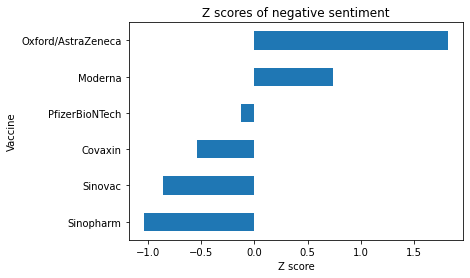

In [ ]:
# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['negative', 'neutral', 'positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('negative_zscore')['negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

## Analysis using Word Cloud

We will generate word clouds to see which words are indicative of each sentiment.

In [ ]:
!pip install wordninja
!pip install pyspellchecker

     |████████████████████████████████| 542kB 28.7MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541553 sha256=34105ef4da6b184f87a09983c2f79b4a3c06bc9992a00502bd266b962af67ef4
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
     |████████████████████████████████| 2.7MB 39.0MB/s 


In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# FUNCTIONS REQUIRED

def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

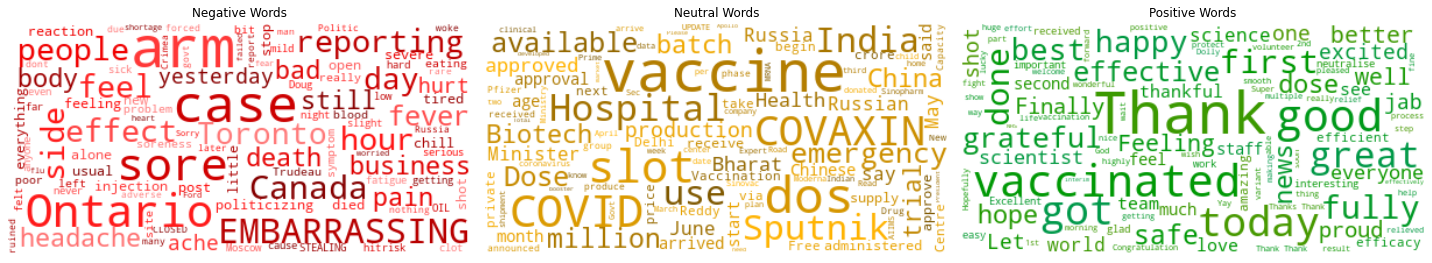

In [ ]:
# Convert string to a list of words
vax_tweets['words'] = vax_tweets.text.apply(lambda x:re.findall(r'\w+', x ))

def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
get_smart_clouds(vax_tweets)

* The positive tweets appear to be from people who have just received their first vaccine or are grateful for the job scientists and healthcare workers are doing.
* The negative tweets seem to be from people who have suffered adverse reactions to the vaccine. 
* The neutral tweets seem to be more like news, which could explain why it is the most prevelant sentiment; in fact, the vast majority of tweets contain urls

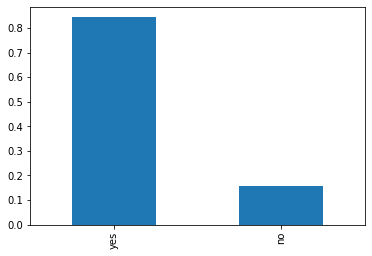

In [ ]:
vax_tweets['has_url'] = np.where(vax_tweets['orig_text'].str.contains('http'), 'yes', 'no')
vax_tweets['has_url'].value_counts(normalize=True).plot.bar();

Interestingly, Canada shows up in the negative word cloud, as well as a couple of Canadian cities. Looking at a 'naive' word cloud for tweets containing 'Canada' shows us that this appears to be a political/economic issue:

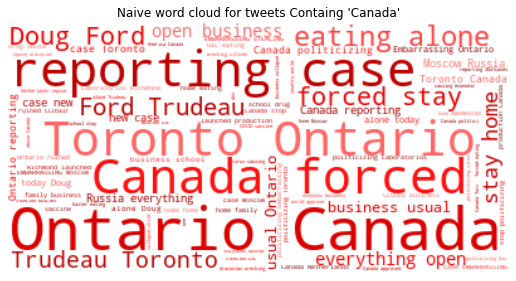

In [ ]:
def get_cloud(df, string, c_func):
    string_l = string.lower()
    df[string_l] = np.where(df['text'].str.lower().str.contains(string_l), 1, 0)
    cloud_df = df.copy()[df[string_l]==1]
    doc = flatten_list(cloud_df['words'])
    doc = [x for x in doc if is_acceptable(x)]
    doc = clean_document(doc)
    fig, axes = plt.subplots(figsize=(9,5))
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(doc))
    axes.imshow(wordcloud.recolor(color_func=c_func, random_state=3), interpolation='bilinear')
    axes.set_title("Naive word cloud for tweets Containg '%s'" % (string))
    axes.axis("off")
    plt.show();
    
get_cloud(vax_tweets, 'Canada', red_color_func)

At the time of writing Canada's vaccination progress has been slower than other developed nations, and people are predicting that it might have an impact on Canada's economic recovery

In [ ]:
countries = ['Canada', 'United Kingdom', 'United States', 'Chile', 'Singapore', 'Israel', 'Australia']
selected = vax_progress[vax_progress['country'].isin(countries)]
eu['country'] = 'EU median'
fig = px.line(vax_progress[vax_progress['country'].isin(countries)].append(eu), x='date', y='daily_vaccinations_per_million', color='country',
             title='Daily vaccinations per million (all vaccines) in Canada vs selected other developed nations')
fig.show()

## Conclusion

fastai make NLP really easy and we were able to get quite good results with a limited dataset and not a lot of training time by using the ULMFiT approach. 

To summarise, the steps are:

* Fine-tune a language model to predict the next word in a tweet, using a model pre-trained on Wikipedia.
* Fine-tune a classification model to predict tweet sentiment using the pre-trained language model.
* Apply the classifier to unlabelled tweets to analyse sentiment.

We were also able to use the model to gain a lot of insights about how sentiment has changed over time for each vaccine and how that relates to the overall progress of vaccination programmes in different countries.